# HW2 - Convolutional Neural Network



In [51]:
# We are going to install Grad-CAM python package 
# which is used to visualize network gradients. 
# Utilized Grad-CAM GitHub repository: https://github.com/jacobgil/pytorch-grad-cam
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Good old Imports 

In [52]:
import os
import torch
import torchvision
import tarfile
from torchvision import transforms, transforms
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
from torch.nn import functional as F
from itertools import chain
import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import FashionMNIST

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


## Data Preparation 

In [53]:
#Define a transform to convert to images to tensor and normalize
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5))]) 
# mean and std have to be sequences (e.g., tuples), 
# therefore we should add a comma after the values

# Download and use FashionMNIST dataset
train_set = FashionMNIST(root='fashion-mnist', download=True, train=True, transform=transform)
test_set = FashionMNIST(root='fashion-mnist', download=True, train=False, transform=transform)

In [54]:
# Using GPU if it's available
use_cuda = torch.cuda.is_available()

# split training set into train and validation data
train_size = 48000
val_size = 60000 - train_size
train_ds, val_ds = random_split(train_set, [train_size, val_size], generator=torch.Generator().manual_seed(123))

In [55]:
# Loading the dataset into memory using Dataloader
# use your desired batch size and shuffle is necessary
tbs, vbs, ttbs = 64, 64, 64

train_dl = DataLoader(train_set, batch_size=tbs, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=vbs, shuffle=True)
test_dl = DataLoader(test_set, batch_size=ttbs, shuffle=True)
classes = train_set.classes

loaders_scratch = {'train': train_dl, 'valid': val_dl, 'test': test_dl}

## Model Training

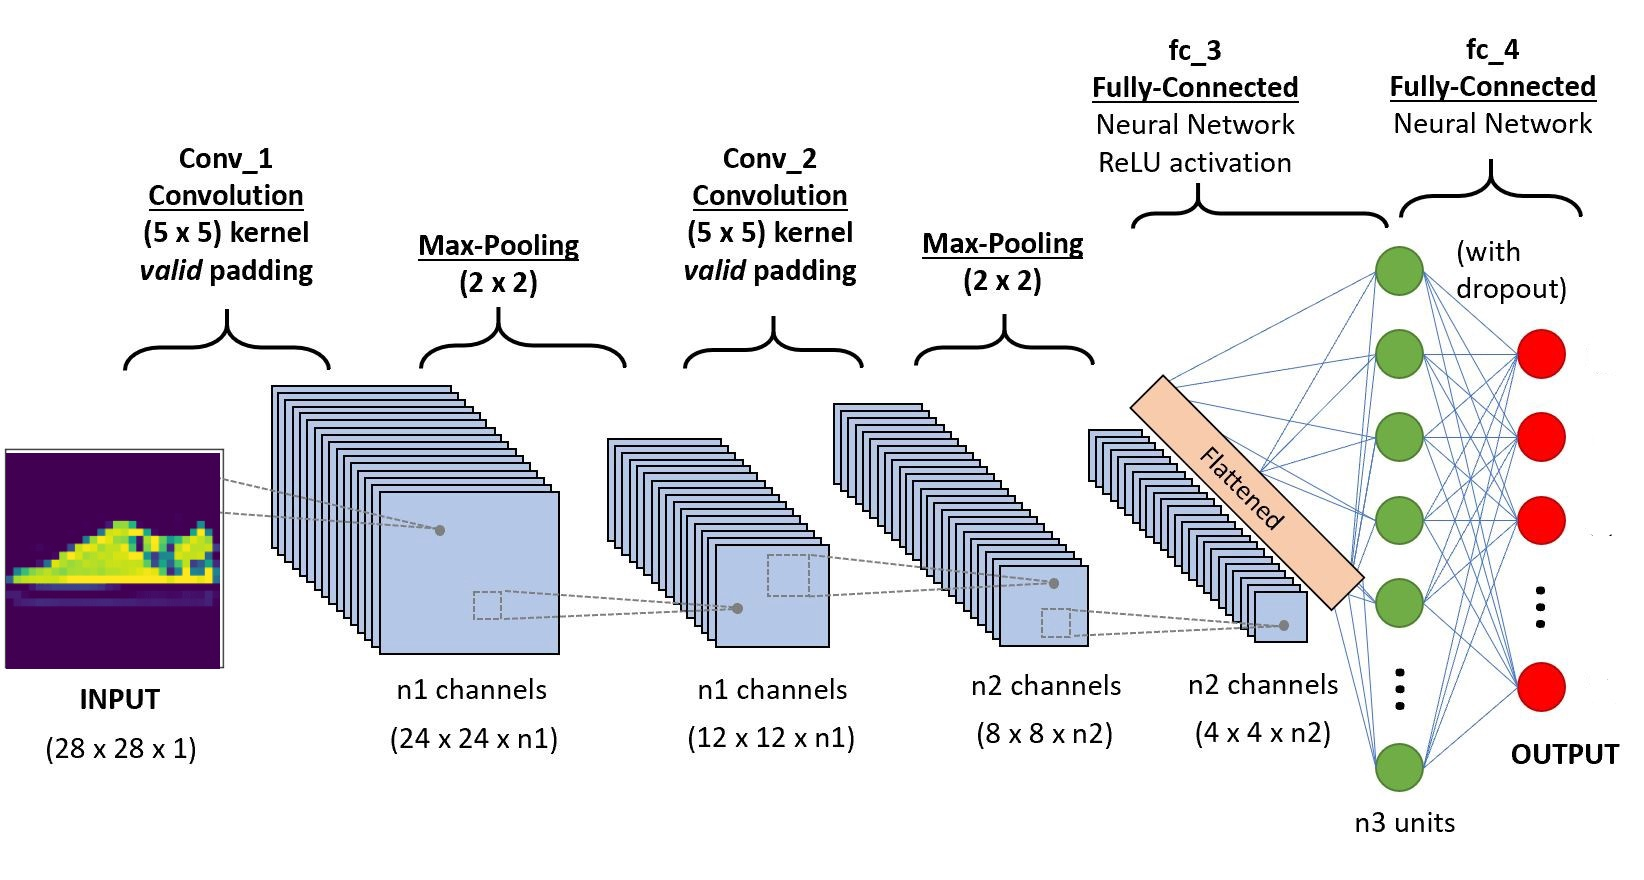

Just Implement model above in pytorch! 

In [56]:
import torch.nn as nn
import torch.nn.functional as F
#define the CNN architecture
class Model(nn.Module):
    def __init__(self, use_dropout=False):
        super(Model, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, kernel_size=(5,5), stride=(1,1))
        self.conv2 = nn.Conv2d(6, 10, kernel_size=(5,5), stride=(1,1))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout2d(0.25)
        self.use_dropout = use_dropout
        self.fc3 = nn.Linear(in_features=160, out_features=56, bias=True)
        self.fc4 = nn.Linear(in_features=56, out_features=10, bias=True)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)

        x = self.pool(x)

        x = self.conv2(x)
        x = F.relu(x)
        
        x = self.pool(x)

        x = torch.flatten(x,1)
        
        x = self.fc3(x)
        x = F.relu(x)

        if self.use_dropout:
            x = self.dropout(x)

        x = self.fc4(x)

        return x

    def predict(self, x):
        # get the predicted class of x.
        # use softmax and then get the maximum indexes
        x = self.forward(x)
        x = self.softmax(x)
        prediction=torch.argmax(x, dim=1)
        return prediction

In [58]:
# Loss function 
# import torch.nn as nn
import torch.optim as optim
criterion_scratch = nn.CrossEntropyLoss() 

def get_optimizer_scratch(model):
    optimizer = optim.SGD(model.parameters(), lr = 0.04)
    return optimizer

In [59]:
# Implementing the training algorithm
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    if use_cuda:
        model = model.cuda()

    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        # train phase #
        # *setting the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            # if use_cuda:
            #     data = data.cuda()
            #     target = target.cuda()
            data, target = data.to(device), target.to(device)

            # train 
            optimizer.zero_grad()

            train_output = model(data)

            pred_labels = torch.softmax(train_output, dim=1)

            loss = criterion(train_output, target)
            # if use_cuda:
            #     loss.cuda()
            # Backward and optimize
            # print(type(loss.item()))
            loss.backward()
            optimizer.step()
            train_loss = loss.item()

        # validate the model #
        # *set the model to evaluation mode
        n_correct=0
        model.eval()
        # Validation
        with torch.no_grad():

            y_true, y_pred = \
            torch.tensor([], dtype=torch.float, device='cuda' if use_cuda else 'cpu'),\
            torch.tensor([], dtype=torch.float, device='cuda' if use_cuda else 'cpu')
            val_losses_sum = 0          

            for batch_idx, (data, target) in enumerate(loaders['valid']):
                # move to GPU
                if use_cuda:
                    # model = model.cuda()
                    data = data.cuda()
                    target = target.cuda()

                val_output = model(data)
                
                y_true = torch.cat([y_true, target])
                y_pred = torch.cat([y_pred, model.predict(data)])
                
                val_losses_sum += criterion(val_output, target)

            n_correct += (y_true == y_pred).sum().item()
            # calculating loss after each batch (iteration)
            valid_avg_loss = val_losses_sum/(len(loaders['valid']))
            val_accuracy = n_correct/len(y_true)

        # print training/validation statistics 
        print('Epoch: {} Training Loss: {:.6f} Validation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_avg_loss
            ))
        
        ## If the valiation loss has decreased, then saving the model
        if valid_avg_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}) (Accuracy: {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_avg_loss,
            val_accuracy))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_avg_loss 
            
    return model

In [48]:
num_epochs = 3

model_scratch = Model()
model_scratch.to(device)
optim_scratch = get_optimizer_scratch(model_scratch)


In [61]:
train(num_epochs, loaders_scratch, model_scratch, optim_scratch, criterion_scratch, use_cuda, "./myModel")

Epoch: 1 Training Loss: 0.226365 Validation Loss: 0.366710
Validation loss decreased (inf --> 0.366710) (Accuracy: 0.868417).  Saving model ...
Epoch: 2 Training Loss: 0.282693 Validation Loss: 0.353906
Validation loss decreased (0.366710 --> 0.353906) (Accuracy: 0.869167).  Saving model ...
Epoch: 3 Training Loss: 0.532664 Validation Loss: 0.369993


Model(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.25, inplace=False)
  (fc3): Linear(in_features=160, out_features=56, bias=True)
  (fc4): Linear(in_features=56, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [63]:
from torch.autograd.grad_mode import no_grad
def test(loaders, model, criterion, use_cuda):

    # set the module to evaluation mode
    model.eval()

    with torch.no_grad():

        y_test_true, y_test_pred = \
        torch.tensor([], dtype=torch.float, device='cuda' if use_cuda else 'cpu'),\
        torch.tensor([], dtype=torch.float, device='cuda' if use_cuda else 'cpu')
        # monitor test loss and accuracy
        test_loss = 0.
        correct = 0.
        total_data = 0.          

        for batch_idx, (data, target) in enumerate(loaders['test']): # runs for len(loaders_scratch['test'])=157 times
            # move to GPU
            if use_cuda:
                model = model.cuda()
                data = data.cuda()
                target = target.cuda()

            test_output = model(data)
            y_test_true = torch.cat([y_test_true, target])
            y_test_pred = torch.cat([y_test_pred, model.predict(data)])
            
            test_loss += criterion(test_output, target)
            total_data += len(test_output)
            # print('Batch: %d\nLoss=%f\nTottalLoss=%f ' % (batch_idx,criterion(test_output, target),test_loss))
        correct = (y_test_true == y_test_pred).sum().item()
        test_avg_loss = test_loss/len(loaders['test'])
        test_accuracy = correct/total_data
        print('Test Loss: {:.6f}\n'.format(test_avg_loss))
        print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
            100*test_accuracy, correct, total_data))

# load the model that got the best validation accuracy
# Use this URL as the documentation:
# https://pytorch.org/tutorials/beginner/saving_loading_models.html
# model_scratch.load_state_dict(...)

trained_model_noDO = Model()
trained_model_noDO.load_state_dict(torch.load("./myModel", map_location=device))
trained_model_noDO.to(device)
test(loaders_scratch, trained_model_noDO, criterion_scratch, use_cuda)

Test Loss: 0.391744


Test Accuracy: 85% (8559/10000)


In [64]:
from math import ceil

import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as VisionF

plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs:torch.Tensor, colsCount:int=1, labelsOfImages:list=[], labelsRefList:list=[], cMap:str='gray'):
    
    if not isinstance(imgs, list):
        imgs = [imgs]

    rowsCount = ceil(len(imgs)/colsCount)
    fig, axs = plt.subplots(ncols=colsCount, nrows=rowsCount, squeeze=False)

    for col_counter in range(colsCount):
        for row_counter in range(rowsCount):
            img_idx = col_counter*rowsCount + row_counter
            if(img_idx > len(imgs)-1):
                axs[row_counter, col_counter].axis('off')
            else:
                img = imgs[img_idx]
                img = img.detach()
                img = VisionF.to_pil_image(img)
                axs[row_counter, col_counter].imshow(np.asarray(img), cmap=cMap)
                axs[row_counter, col_counter].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], xlabel=labelsRefList[labelsOfImages[img_idx]] if len(labelsOfImages)>0 and len(labelsRefList)>0 else '')
    return fig, axs

In [80]:
def predict_image(img,  model:Model, trueLabel:int=-1):
    # plot the image!
    model=model.to(device)
    img=img.to(device)
    model.eval()
    preds = model.predict(img.unsqueeze(0))
    show(img, labelsOfImages=[preds[0].item()], labelsRefList=train_set.classes)
    return train_set.classes[preds[0].item()]

True label: Pullover
Predicted label: Pullover


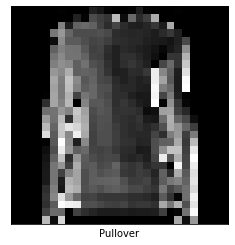

In [81]:
img, label = test_set[321]
predLabel = predict_image(img, trained_model_noDO)
print(f'True label: {train_set.classes[label]}\nPredicted label: {predLabel}')

 ## Data Augmentation and dropout

 Here You should implement data augmentation and dropout for your model and train it again. 
 
 Does it perform better? 
 
 You can also use another augmentation to see how it affects the model (extra point). 

In [82]:
# compose a transform using transforms.Compose that horizontally flips images 
# and use transforms.RandomResizedCrop to crop a 20 * 20 patch of the image 
# and resizing back to 28 * 28

# RandomResizedCrop
# RandomHorizontalFlip
# https://pytorch.org/vision/stable/transforms.html#transforms-on-pil-image-and-torch-tensor

# A sample list of transforms:
# https://medium.com/dejunhuang/learning-day-23-data-augmentation-in-pytorch-e375e19100c3
#################################################################################
augmentation_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                             transforms.RandomResizedCrop([20,20]),
                                             transforms.Resize([28,28]),
                                             transforms.ToTensor(),
                                             transforms.Normalize((0.5), (0.5))]) 

augmented_train_set = FashionMNIST(root='fashion-mnist', download=True, train=True, transform=augmentation_transforms)
# augmented_test_set = FashionMNIST(root='fashion-mnist', download=True, train=False, transform=augmentation_transform)
test_set = FashionMNIST(root='fashion-mnist', download=True, train=False, transform=transform)

tbs, vbs, ttbs = 64, 64, 64
train_size = 48000
val_size = 60000 - train_size

ag_train_ds, ag_val_ds = random_split(augmented_train_set, [train_size, val_size], generator=torch.Generator().manual_seed(123))

ag_train_dl = DataLoader(ag_train_ds, batch_size=tbs, shuffle=True)
ag_val_dl = DataLoader(ag_val_ds, batch_size=vbs, shuffle=True)
test_dl = DataLoader(test_set, batch_size=ttbs, shuffle=True)

classes = train_set.classes

ag_loaders_scratch = {'train': ag_train_dl, 'valid': ag_val_dl, 'test': test_dl}

In [86]:
# retrain the model using augmented data. also add a dropout layer in model.
# Loss function 
# import torch.nn as nn

ag_model_withDO = Model(True)
ag_model_withDO.to(device)

ag_criterion_scratch = nn.CrossEntropyLoss()

ag_optim_scratch = get_optimizer_scratch(ag_model_withDO)

ag_num_epochs = 50

train(ag_num_epochs, ag_loaders_scratch, ag_model_withDO, ag_optim_scratch, ag_criterion_scratch, use_cuda, "./ag_myModel_withDO")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 1 Training Loss: 1.277176 Validation Loss: 1.396101
Validation loss decreased (inf --> 1.396101) (Accuracy: 0.490917).  Saving model ...
Epoch: 2 Training Loss: 1.303421 Validation Loss: 1.156662
Validation loss decreased (1.396101 --> 1.156662) (Accuracy: 0.572667).  Saving model ...
Epoch: 3 Training Loss: 1.004260 Validation Loss: 1.075384
Validation loss decreased (1.156662 --> 1.075384) (Accuracy: 0.598750).  Saving model ...
Epoch: 4 Training Loss: 1.127151 Validation Loss: 1.083165
Epoch: 5 Training Loss: 1.076271 Validation Loss: 1.024212
Validation loss decreased (1.075384 --> 1.024212) (Accuracy: 0.622333).  Saving model ...
Epoch: 6 Training Loss: 1.287845 Validation Loss: 0.998090
Validation loss decreased (1.024212 --> 0.998090) (Accuracy: 0.632250).  Saving model ...
Epoch: 7 Training Loss: 1.063620 Validation Loss: 1.026685
Epoch: 8 Training Loss: 1.117039 Validation Loss: 0.962188
Validation loss decreased (0.998090 --> 0.962188) (Accuracy: 0.645833).  Saving mod

Model(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.25, inplace=False)
  (fc3): Linear(in_features=160, out_features=56, bias=True)
  (fc4): Linear(in_features=56, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [87]:
augmentation2_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                            transforms.RandomVerticalFlip(),
                                            transforms.RandomRotation(15),
                                            transforms.RandomRotation([90, 180]),
                                            transforms.Resize([25, 25]),
                                            transforms.RandomCrop([28, 28]),
                                            transforms.ToTensor()]) 

augmented_extrapoint_train_set = FashionMNIST(root='fashion-mnist', download=True, train=True, transform=augmentation2_transforms)
test_set = FashionMNIST(root='fashion-mnist', download=True, train=False, transform=transform)

ag_exp_train_ds, ag_exp_val_ds = random_split(augmented_extrapoint_train_set, [train_size, val_size], generator=torch.Generator().manual_seed(123))

agEx_train_dl = DataLoader(ag_train_ds, batch_size=tbs, shuffle=True)
agEx_val_dl = DataLoader(ag_val_ds, batch_size=vbs, shuffle=True)
test_dl = DataLoader(test_set, batch_size=ttbs, shuffle=True)

classes = train_set.classes

agEx_loaders_scratch = {'train': agEx_train_dl, 'valid': agEx_val_dl, 'test': test_dl}

In [88]:
# retrain the model using augmented data. also add a dropout layer in model.
agEx_model_withDO = Model(True)
agEx_model_withDO.to(device)

agEx_criterion_scratch = nn.CrossEntropyLoss()

agEx_optim_scratch = get_optimizer_scratch(agEx_model_withDO)

agEx_num_epochs = 30

train(agEx_num_epochs, agEx_loaders_scratch, agEx_model_withDO, agEx_optim_scratch, agEx_criterion_scratch, use_cuda, "./agEx_myModel_withDO")

Epoch: 1 Training Loss: 1.420338 Validation Loss: 1.311268
Validation loss decreased (inf --> 1.311268) (Accuracy: 0.514583).  Saving model ...
Epoch: 2 Training Loss: 1.349924 Validation Loss: 1.166755
Validation loss decreased (1.311268 --> 1.166755) (Accuracy: 0.572500).  Saving model ...
Epoch: 3 Training Loss: 1.041688 Validation Loss: 1.077973
Validation loss decreased (1.166755 --> 1.077973) (Accuracy: 0.595917).  Saving model ...
Epoch: 4 Training Loss: 1.319037 Validation Loss: 1.033517
Validation loss decreased (1.077973 --> 1.033517) (Accuracy: 0.607833).  Saving model ...
Epoch: 5 Training Loss: 1.166778 Validation Loss: 0.980429
Validation loss decreased (1.033517 --> 0.980429) (Accuracy: 0.636333).  Saving model ...
Epoch: 6 Training Loss: 1.145041 Validation Loss: 0.980104
Validation loss decreased (0.980429 --> 0.980104) (Accuracy: 0.631083).  Saving model ...
Epoch: 7 Training Loss: 1.200262 Validation Loss: 0.986180
Epoch: 8 Training Loss: 1.014660 Validation Loss: 0.

Model(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.25, inplace=False)
  (fc3): Linear(in_features=160, out_features=56, bias=True)
  (fc4): Linear(in_features=56, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

## GradCam

> [Grad-CAM | Lecture 28 (Part 2) | Applied Deep Learning - YouTube](https://www.youtube.com/watch?v=nBqdUAYxLjs)

In this part GradCAM is used to explain the model results. The output should be a heatmap image which shows which regions are the most important. 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


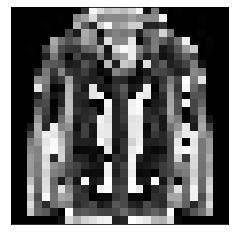

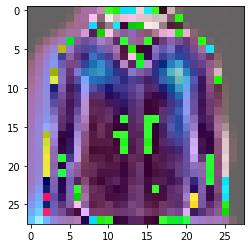

In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import matplotlib.pyplot as plt
import cv2

idx = 5743 
target_layers = [ag_model_withDO.conv1, ag_model_withDO.conv2]
# Create an input tensor image for your model..
input_tensor = test_set[idx][0].unsqueeze(0)
img = np.asarray(test_set[idx][0])
# Note: input_tensor can be a batch tensor with several images!
# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=ag_model_withDO, target_layers=target_layers, use_cuda=use_cuda)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets = [ClassifierOutputTarget(1)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
# show(torch.Tensor(grayscale_cam), cMap='inferno')
pltt,_=show(test_set[idx][0])
visualization = show_cam_on_image(img.reshape((28,28,1)), grayscale_cam, colormap=cv2.COLORMAP_INFERNO)
plt.show(pltt)
plt.imshow(visualization)